## Regression with Google Maps dataset

The  task is to find one corner (vertex) of a building in each image. The data comes from screenshots of Google Maps

In [357]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [358]:
from fastai.vision import *

## Getting and converting the data

In [359]:
path = untar_data('perimeter_data')
path.ls()

[PosixPath('/Users/ellioteckholm/Documents/AI/perimeter_model/data/perimeter_data/02'),
 PosixPath('/Users/ellioteckholm/Documents/AI/perimeter_model/data/perimeter_data/.DS_Store'),
 PosixPath('/Users/ellioteckholm/Documents/AI/perimeter_model/data/perimeter_data/test'),
 PosixPath('/Users/ellioteckholm/Documents/AI/perimeter_model/data/perimeter_data/models'),
 PosixPath('/Users/ellioteckholm/Documents/AI/perimeter_model/data/perimeter_data/01')]

In [388]:
fname = '01/4_rgb.jpg'

In [380]:
def img2txt_name(f): return path/f'{str(f)[:-8]}.txt'

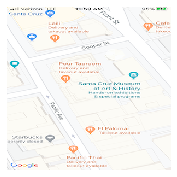

In [381]:
img = open_image(path/fname)
img.show()

In [382]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=0); ctr

array([ 80., 109.])

In [383]:
def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(fname), skip_header=0)
    ctr[[0, 1]] = ctr[[1, 0]]
    return tensor([ctr])

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [384]:
get_ctr(fname)

tensor([[109.,  80.]], dtype=torch.float64)

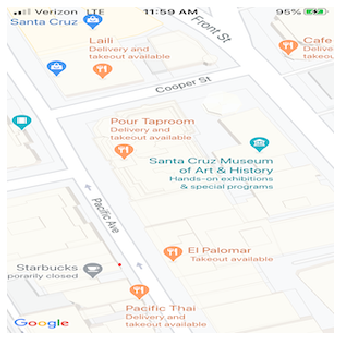

In [389]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [377]:

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='test')
        .label_from_func(get_ctr)
        .transform(size=(300,300))
        .databunch(bs = 5,num_workers = 0).normalize()
      )




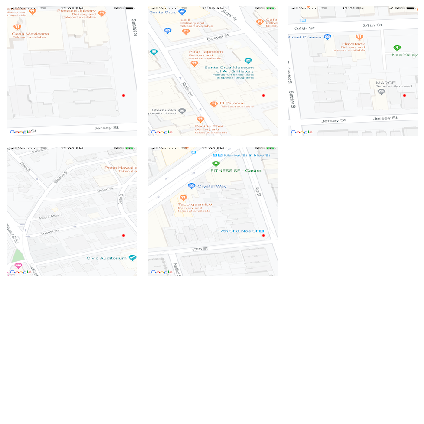

In [378]:
data.show_batch(7, figsize=(6,6))

## Train model

In [346]:
learn = cnn_learner(data, models.resnet34)

In [299]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,2.070652,#na#,00:02
1,1.663183,#na#,00:02
2,3.259569,#na#,00:02
3,3.395442,#na#,00:02
4,3.347575,#na#,00:02
5,3.178958,#na#,00:02
6,3.388491,#na#,00:02
7,3.198602,#na#,00:02
8,3.258526,#na#,00:02
9,3.581629,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [347]:
lr = 2e-2

In [348]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,time
0,2.389940,4.067120,00:03


In [349]:
learn.save('stage-1')

In [350]:
learn.load('stage-1');

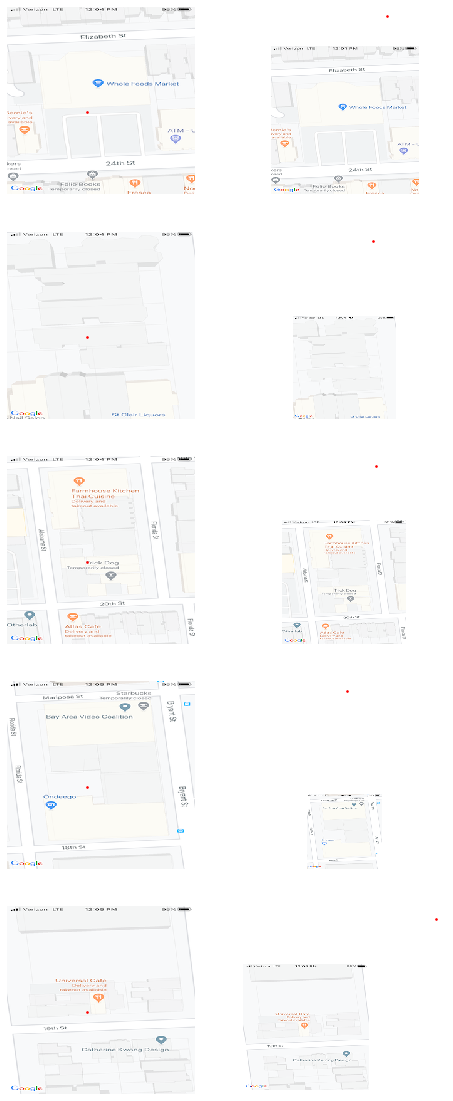

In [351]:
learn.show_results()

## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

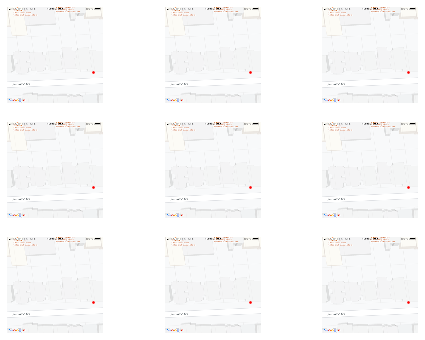

In [390]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))